# Text-Based Depression Detection System

### Analysing the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re
import wordninja

#### Loading Dataset

In [2]:
mental_data = pd.read_csv('mental_health.csv')
mental_data

,text,label
0,dear american teens question dutch person hear...,0
1,nothing look forward lifei dont many reasons k...,1
2,music recommendations im looking expand playli...,0
3,im done trying feel betterthe reason im still ...,1
4,worried year old girl subject domestic physic...,1
...,...,...
27972,posting everyday people stop caring religion ...,0
27973,okay definetly need hear guys opinion ive pret...,0
27974,cant get dog think ill kill myselfthe last thi...,1
27975,whats point princess bridei really think like ...,1


As we can see above, the data set we will be working on includes two columns named as text and label. Texts are labeled as 1 and 0 which means the depressed and non-depressed. In the data set we have 27977 rows in total.

In [3]:
mental_data.isnull().sum()

text     0
label    0
dtype: int64

When we check the data set, we can see that there are no missing values. That means, there is no need to clean the data set before displaying models on it.

In [4]:
mental_data.describe()

,label
count,27977.000000
mean,0.494621
std,0.499980
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [5]:
mental_data['label'].value_counts()

label
0    14139
1    13838
Name: count, dtype: int64

Now since we know the 0 and 1 value numbers, lets visualise the dataset.

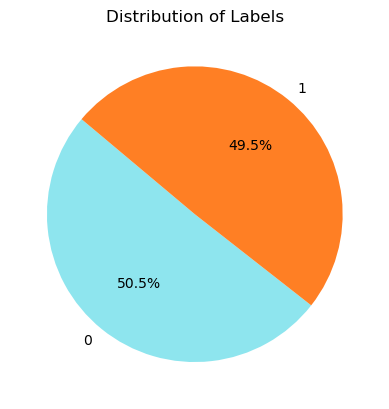

In [6]:
labels = mental_data["label"].value_counts()
colours = ["#8ee5ee" , "#ff7f24"]

plt.pie(labels, labels=labels.index, autopct="%1.1f%%", colors=colours, startangle=140)
plt.title("Distribution of Labels")
plt.show()

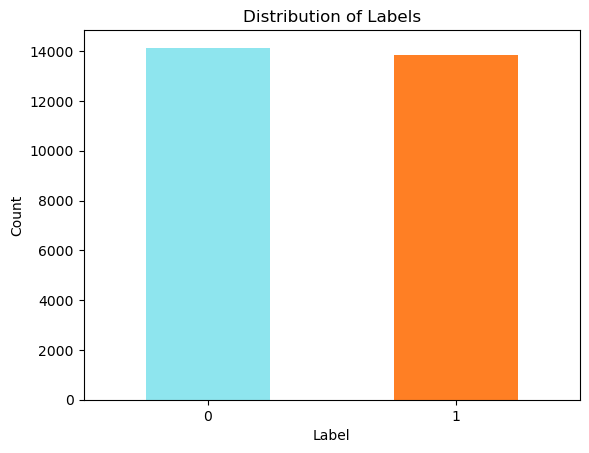

In [7]:
labels.plot(kind="bar", color=["#8ee5ee" , "#ff7f24"])
plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

### Data Preparation

In [8]:
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'  # Adjective
    elif tag.startswith('V'):
        return 'v'  # Verb
    elif tag.startswith('N'):
        return 'n'  # Noun
    elif tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to noun if not found


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/iremhatipoglu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [9]:
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/iremhatipoglu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
nltk.download('wordnet')

def preprocess_text(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove characters and symbols
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    contractions = {
        "aint": "is not", "arent": "are not","cant": "can not", 
        "cause": "because", "couldve": "could have", "couldnt": "could not", 
        "didnt": "did not",  "doesnt": "does not", "dont": "do not", "hadnt": "had not", 
        "hasnt": "has not", "havent": "have not", "hed": "he would", "hes": "he is",
        "howd": "how did", "howll": "how will", "hows": "how is",  "I'd": "I would",
        "I'd've": "I would have", "Ill": "I will",  "Ill've": "I will have","Im": "I am", "I've": "I have", 
        "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "im": "i am" , "i'll've": "i will have","i'm": "i am", 
        "i've": "i have", "isnt": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
        "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
        "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
        "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
        "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
        "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
        "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", 
        "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
        "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", 
        "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
        "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
        "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", 
        "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", 
        "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is",
        "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", 
        "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
        "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
        "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", 
        "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
        "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", 
        "you're": "you are", "you've": "you have"

    }
    
    # Replace contractions
    for contraction, expanded_form in contractions.items():
        text = text.replace(contraction, expanded_form)
    
    # Tokenize the text into words using wordninja
    tokens = wordninja.split(text)

    # Perform POS tagging
    pos_tags = pos_tag(tokens)
    
    # Lemmatization
    lemmatized_tokens = []
    for word, tag in pos_tags:
        pos = get_wordnet_pos(tag)
        lemma = lemmatizer.lemmatize(word, pos=pos)
        lemmatized_tokens.append(lemma)
    
    # Remove stop words
    filtered_tokens = [word for word in lemmatized_tokens if word.lower() not in stop_words]
    
     # Remove duplicate words
    unique_tokens = []
    for word in filtered_tokens:
        if word not in unique_tokens:
            unique_tokens.append(word)
    
    # Recreate text from unique tokens
    filtered_text = ' '.join(unique_tokens)
    
    return filtered_text


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/iremhatipoglu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
# Apply the preprocess_text function to the cleaned_text column
mental_data['processed_text'] = mental_data['text'].apply(preprocess_text)

mental_data

,text,label,processed_text
0,dear american teens question dutch person hear...,0,dear american teen question dutch person hear ...
1,nothing look forward lifei dont many reasons k...,1,nothing look forward life many reason keep go ...
2,music recommendations im looking expand playli...,0,music recommendation look expand playlist usua...
3,im done trying feel betterthe reason im still ...,1,try feel better reason still alive know mum de...
4,worried year old girl subject domestic physic...,1,worried year old girl subject domestic physica...
...,...,...,...
27972,posting everyday people stop caring religion ...,0,post everyday people stop care religion matter...
27973,okay definetly need hear guys opinion ive pret...,0,okay definetly need hear guys opinion ive pret...
27974,cant get dog think ill kill myselfthe last thi...,1,get dog think ill kill last thing hold yup fir...
27975,whats point princess bridei really think like ...,1,point princess bride really think like wesley ...


### Word Cloud Visualisation

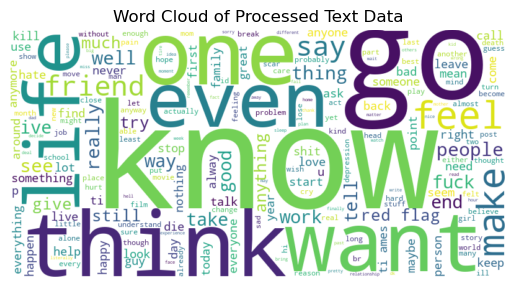

In [12]:
from wordcloud import WordCloud

all_text = ' '.join(mental_data['processed_text']) 

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Processed Text Data')
plt.show()

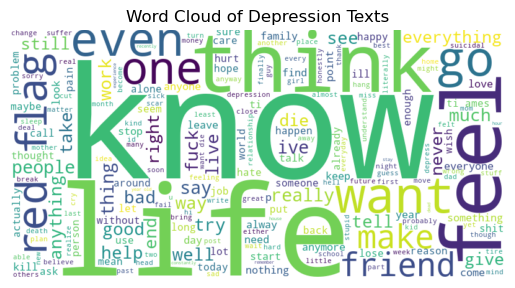

In [13]:
depression_texts = mental_data[mental_data['label'] == 1]['processed_text']

all_depression_text = ' '.join(depression_texts)

wordcloud_depression = WordCloud(width=800, height=400, background_color='white').generate(all_depression_text)

plt.imshow(wordcloud_depression, interpolation='bilinear')
plt.axis('off') 
plt.title('Word Cloud of Depression Texts')
plt.show()

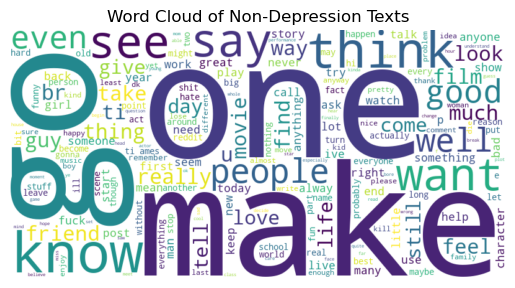

In [14]:
depression_texts = mental_data[mental_data['label'] == 0]['processed_text']

all_depression_text = ' '.join(depression_texts)

wordcloud_depression = WordCloud(width=800, height=400, background_color='white').generate(all_depression_text)

plt.imshow(wordcloud_depression, interpolation='bilinear')
plt.axis('off') 
plt.title('Word Cloud of Non-Depression Texts')
plt.show()

### Word Frequency

/Users/iremhatipoglu/anaconda3/envs/jupyterprojects/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/iremhatipoglu/anaconda3/envs/jupyterprojects/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/iremhatipoglu/anaconda3/envs/jupyterprojects/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


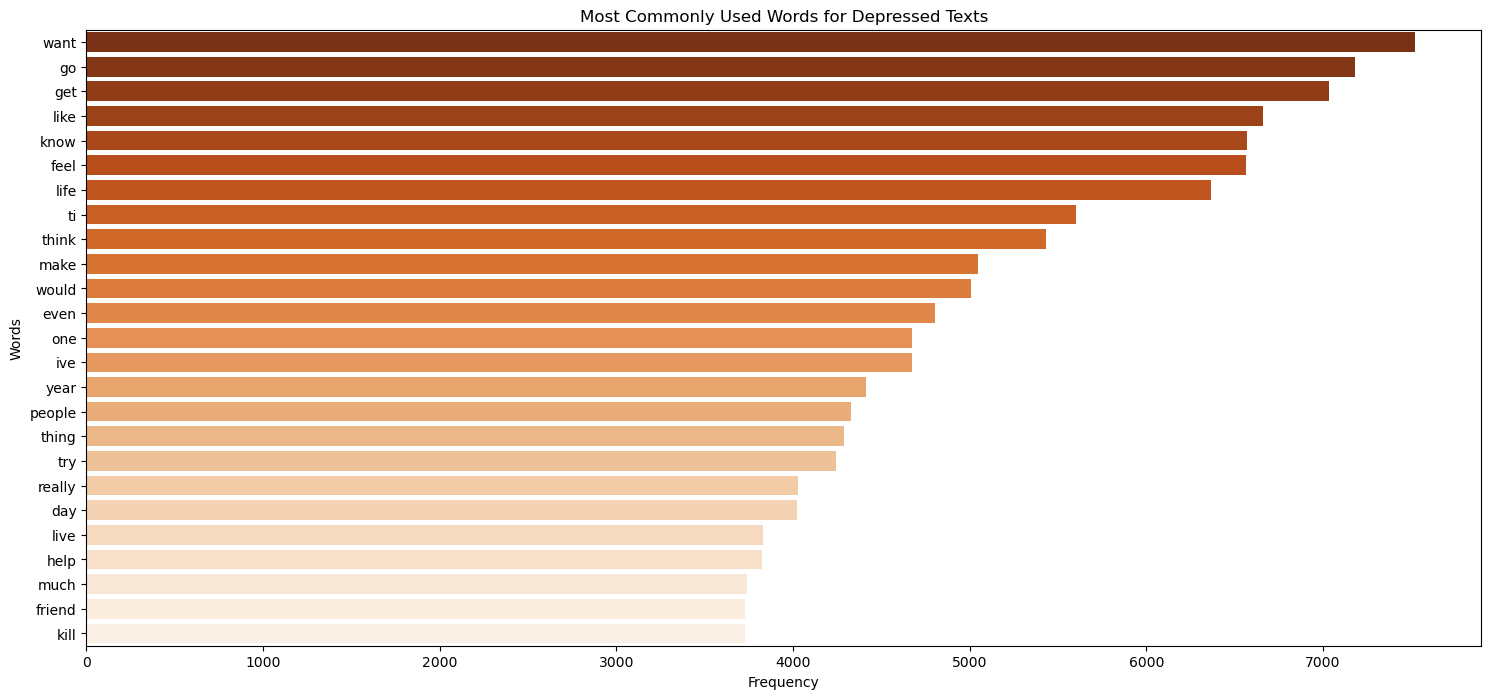

/Users/iremhatipoglu/anaconda3/envs/jupyterprojects/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/iremhatipoglu/anaconda3/envs/jupyterprojects/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/iremhatipoglu/anaconda3/envs/jupyterprojects/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


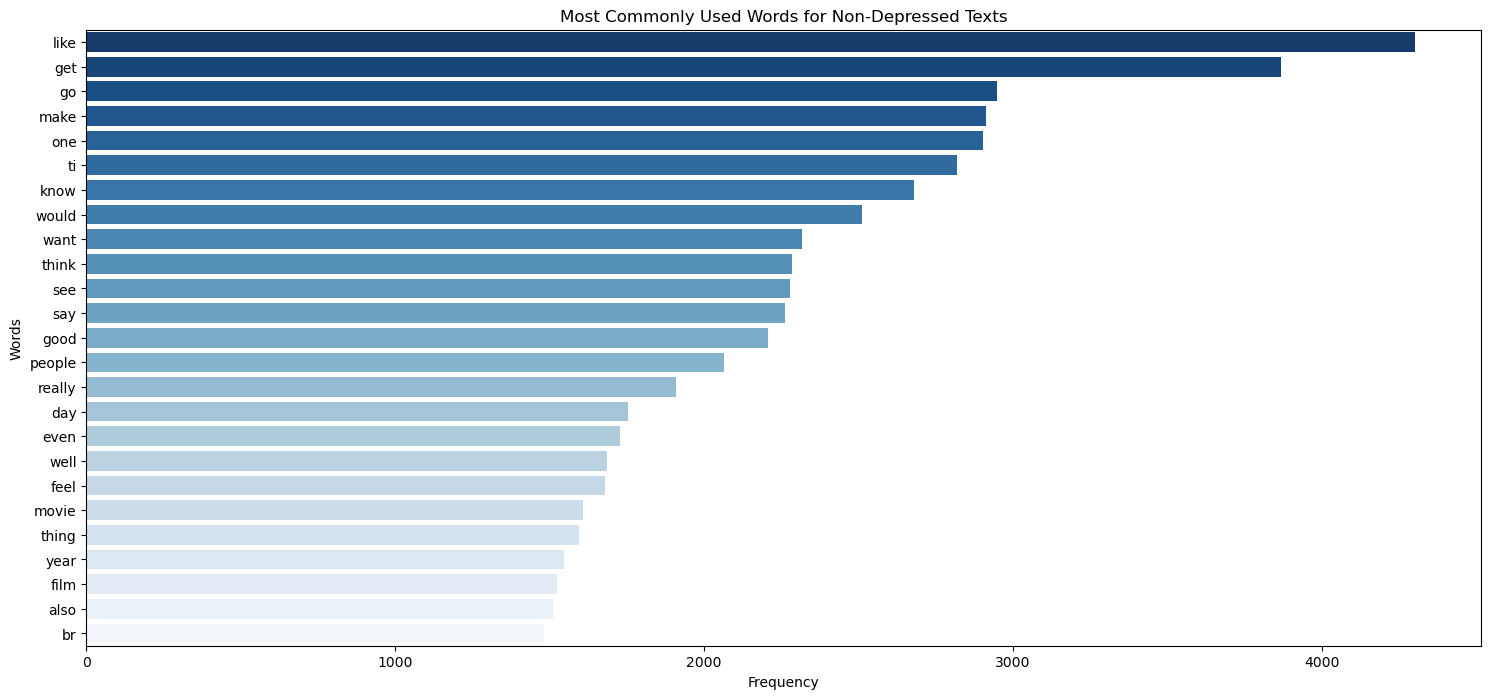

In [15]:
from collections import Counter

all_words_label_0 = []
all_words_label_1 = []

for sentence, label in zip(mental_data['processed_text'], mental_data['label']):
    words = sentence.split()
    if label == 0:
        all_words_label_0.extend(words)
    else:
        all_words_label_1.extend(words)

counter_label_0 = Counter(all_words_label_0)
df_label_0 = pd.DataFrame(counter_label_0.most_common(25), columns=['Word', 'Frequency'])

counter_label_1 = Counter(all_words_label_1)
df_label_1 = pd.DataFrame(counter_label_1.most_common(25), columns=['Word', 'Frequency'])

# Plotting for label 1
plt.figure(figsize=(18, 8))
sns.barplot(y=df_label_1['Word'], x=df_label_1['Frequency'],palette='Oranges_r')
plt.title("Most Commonly Used Words for Depressed Texts")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

# Plotting for label 0
plt.figure(figsize=(18, 8))
sns.barplot(y=df_label_0['Word'], x=df_label_0['Frequency'], palette='Blues_r')
plt.title("Most Commonly Used Words for Non-Depressed Texts")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

### Modelling

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scikitplot.metrics import plot_confusion_matrix, plot_roc
X = mental_data["processed_text"]
y = mental_data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [18]:
X_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [19]:
def train_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    sns.set_context('notebook', font_scale= 1.3)
    fig, ax = plt.subplots(1, 2, figsize = (25,  8))
    ax1 = plot_confusion_matrix(y_test, y_pred, ax= ax[0], cmap='Blues')
    ax2 = plot_roc(y_test, y_prob, ax= ax[1], plot_macro= False, plot_micro= False, cmap='summer')

#### Logistic Regression

Accuracy of the model: 0.917
Precision Score of the model: 0.923
Recall Score of the model: 0.909


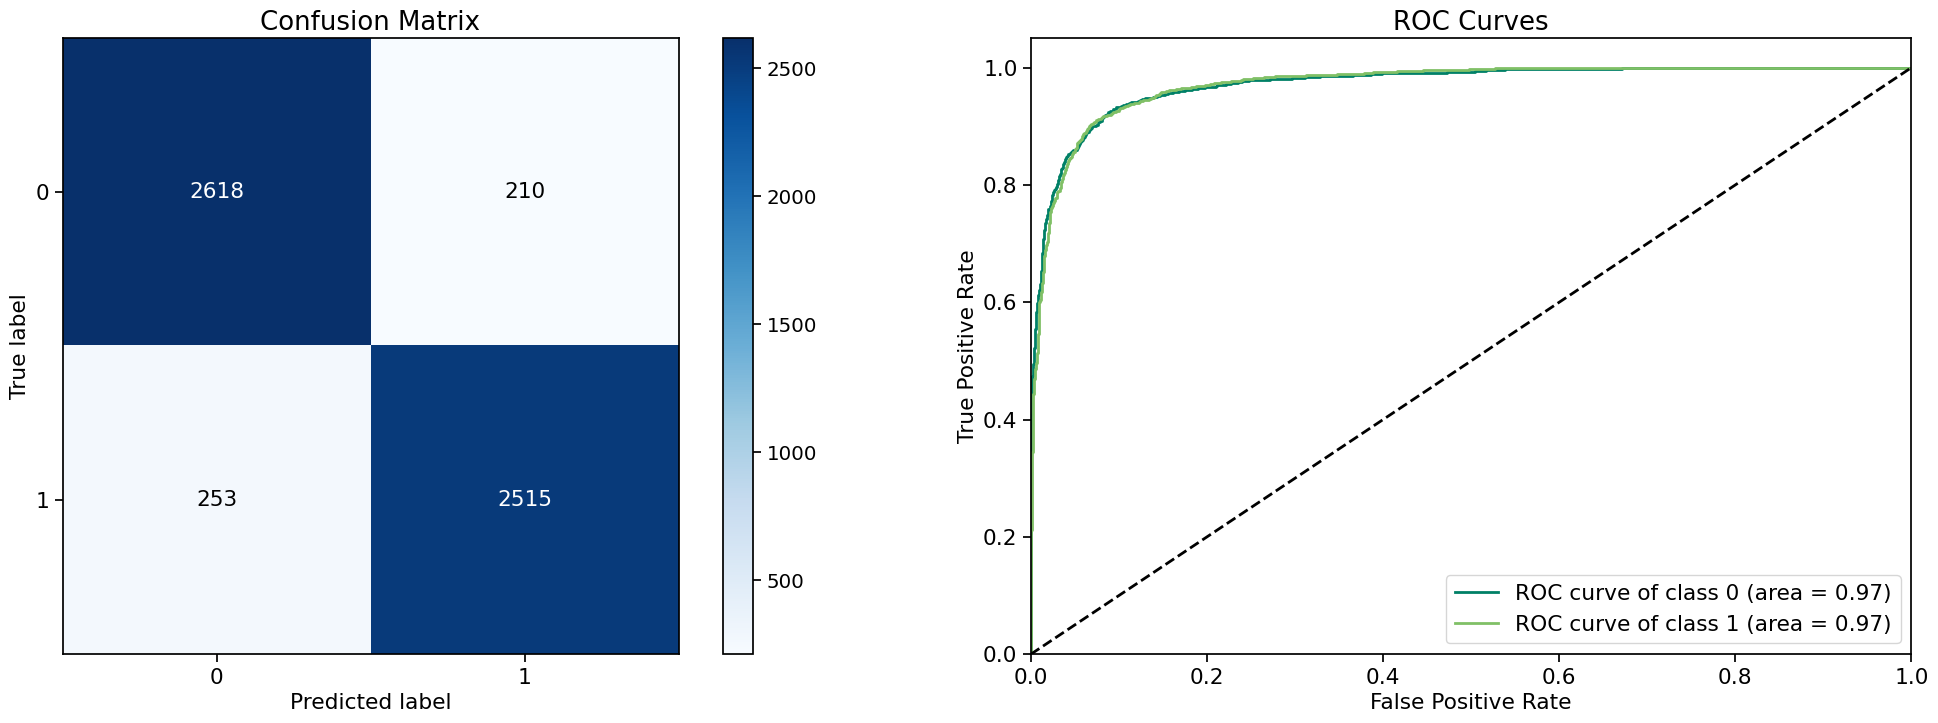

In [20]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression()
train_model(logistic_reg)

#### Naive Bayes

Accuracy of the model: 0.889
Precision Score of the model: 0.847
Recall Score of the model: 0.947


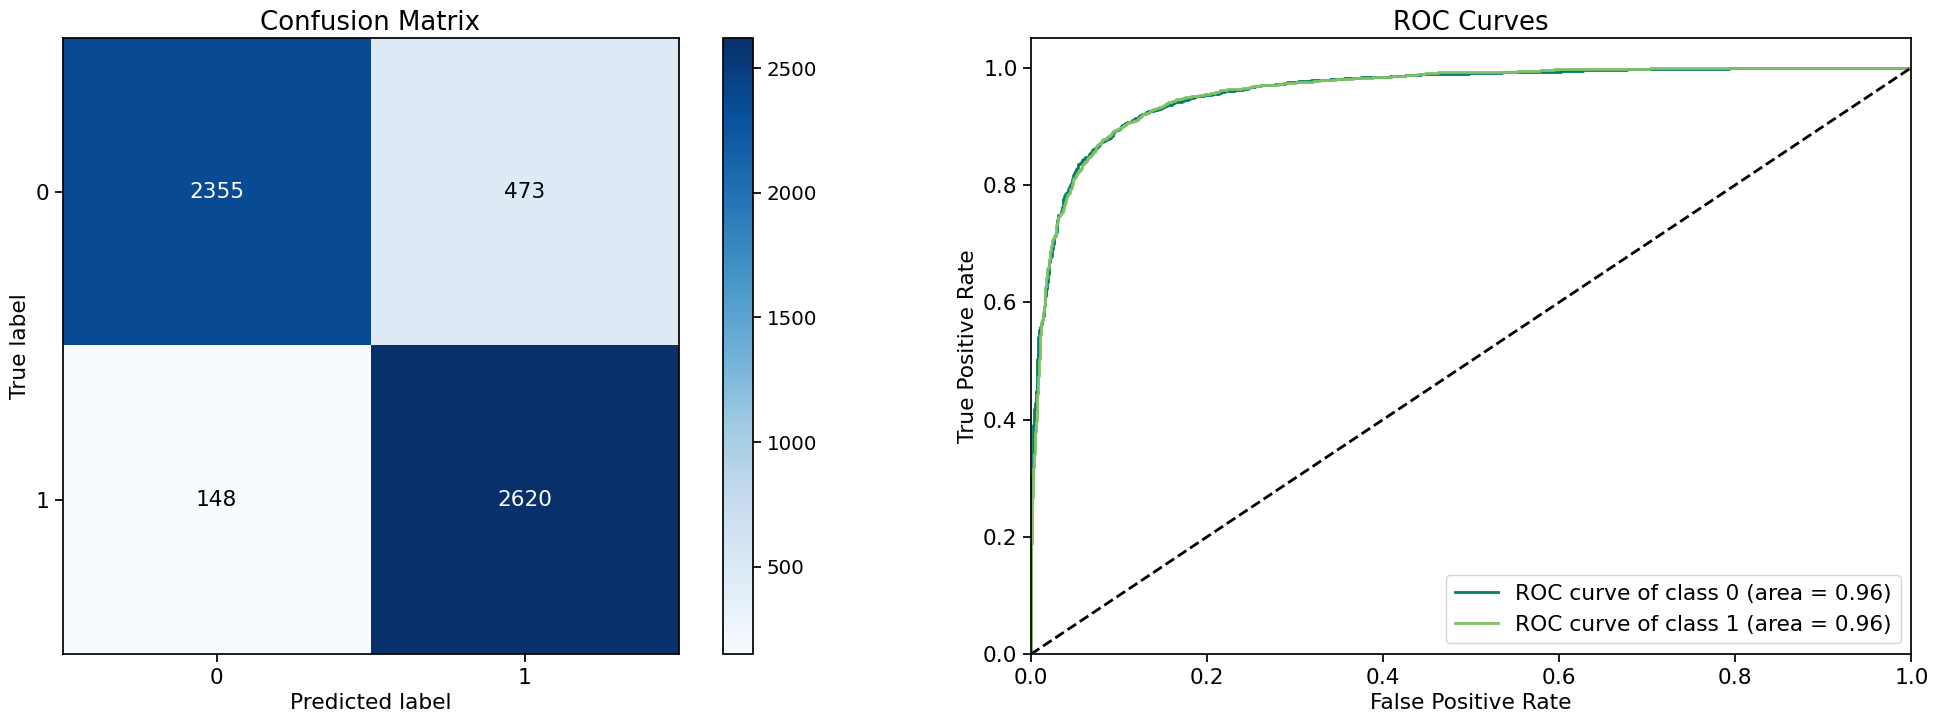

In [21]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
train_model(nb)

#### Decision Tree

Accuracy of the model: 0.83
Precision Score of the model: 0.831
Recall Score of the model: 0.824


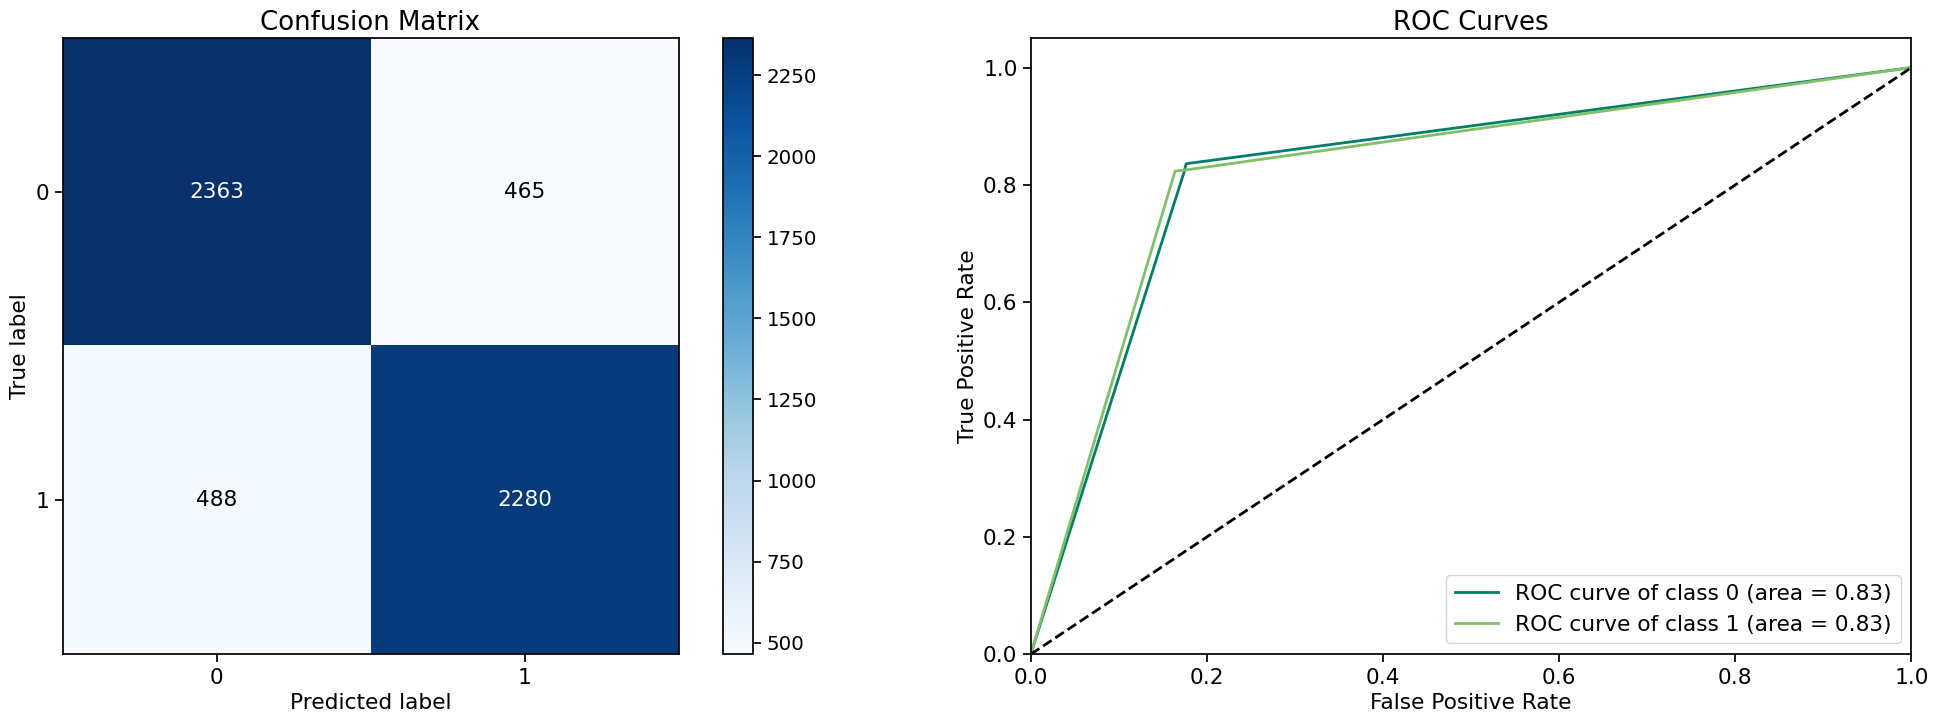

In [22]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
train_model(decision_tree)

#### Random Forest

Accuracy of the model: 0.893
Precision Score of the model: 0.882
Recall Score of the model: 0.905


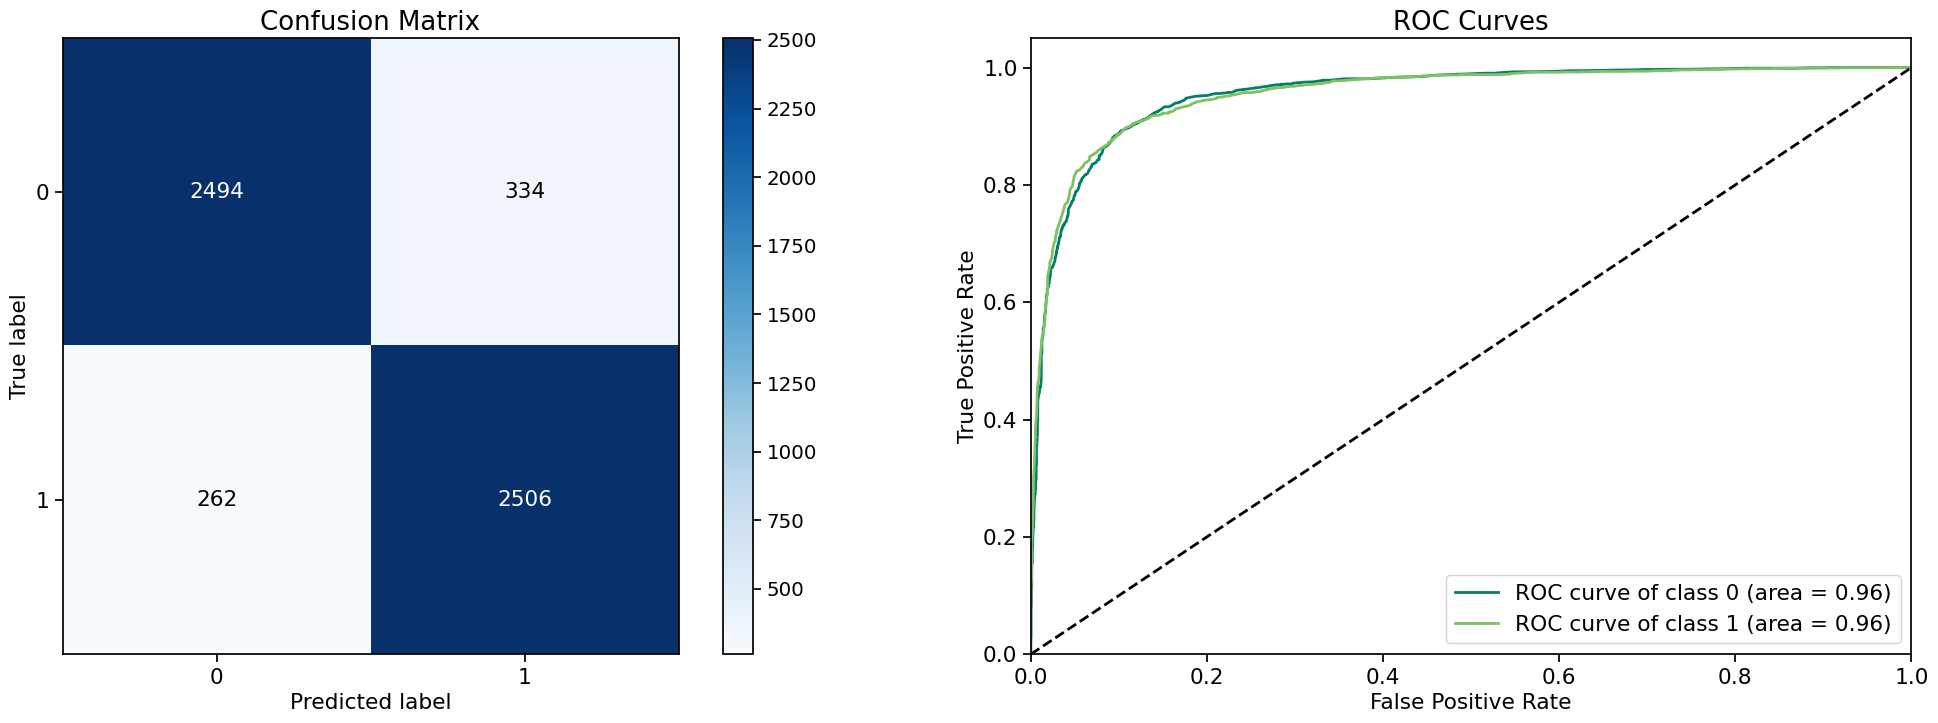

In [23]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators= 300)
train_model(rf)

### SVM

Accuracy of the model: 0.92
Precision Score of the model: 0.926
Recall Score of the model: 0.911


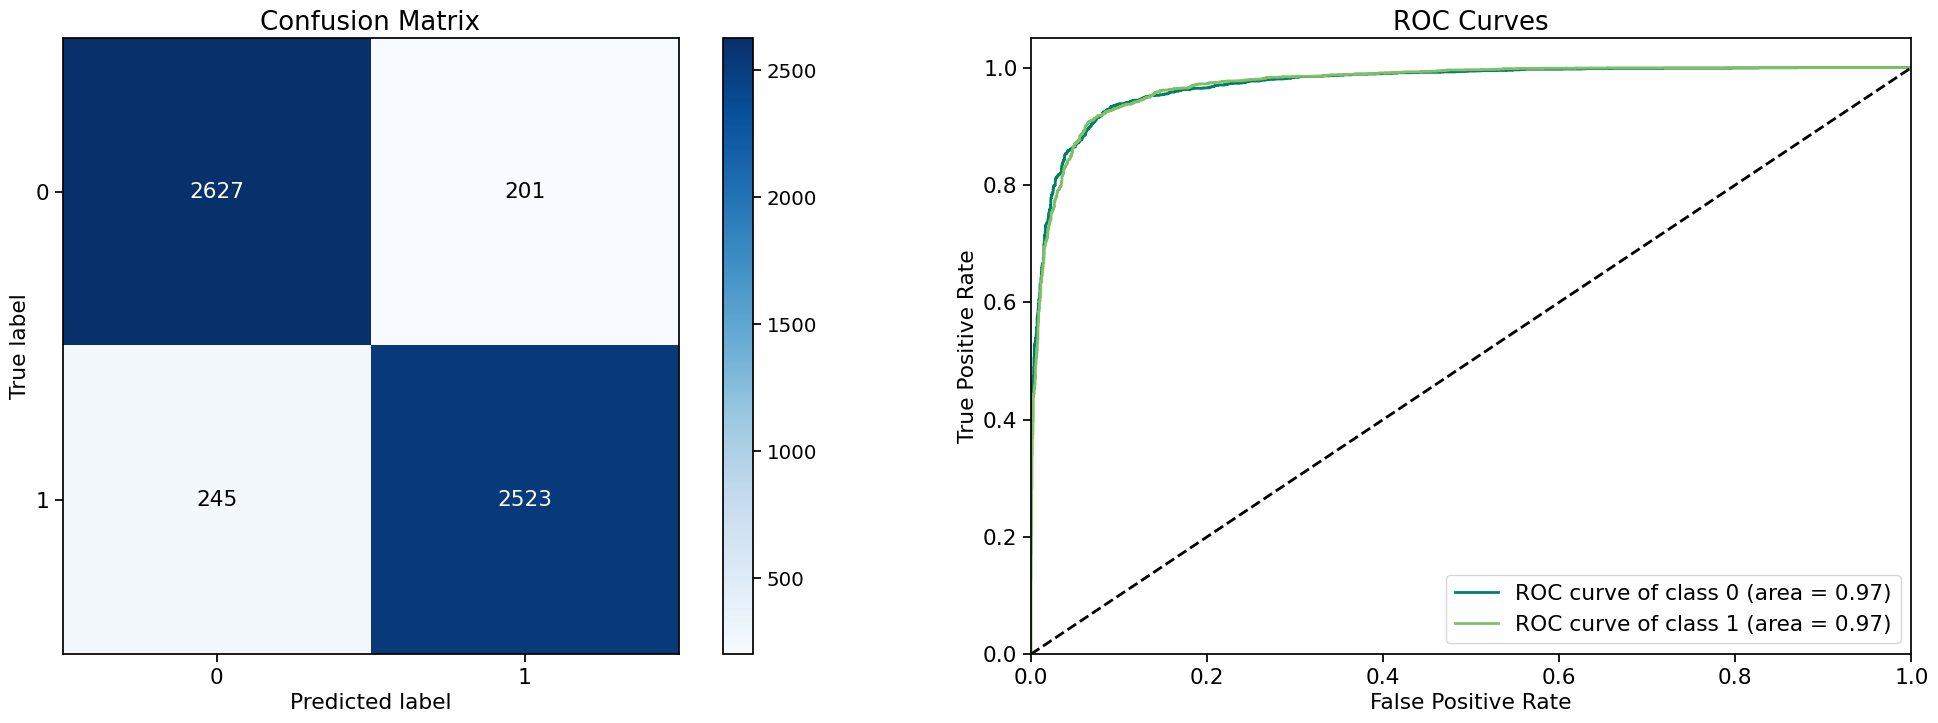

In [24]:
from sklearn.svm import SVC

svm = SVC(probability=True)  # Setting probability=True for using predict_proba
train_model(svm)

In [25]:
def get_accuracy(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    return accuracy

accuracy_scores = {}
accuracy_scores['Logistic Regression'] = get_accuracy(logistic_reg, X_test, y_test)
accuracy_scores['Naive Bayesian'] = get_accuracy(nb, X_test, y_test)
accuracy_scores['Decision Tree'] = get_accuracy(decision_tree, X_test, y_test)
accuracy_scores['Random Forest'] = get_accuracy(rf, X_test, y_test)
accuracy_scores['SVM'] = get_accuracy(svm, X_test, y_test)

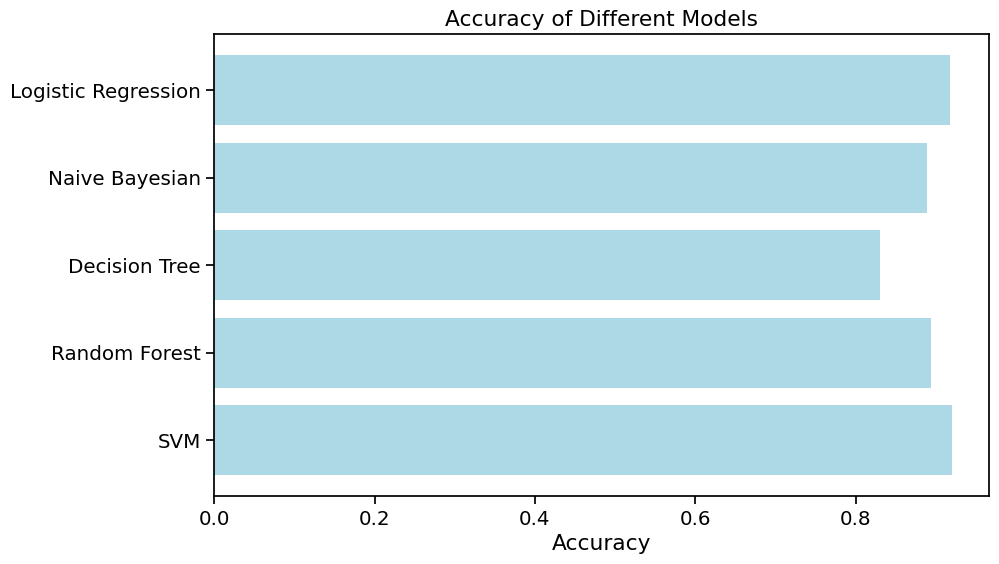

In [26]:
models = list(accuracy_scores.keys())
accuracies = list(accuracy_scores.values())
# Create a histogram
plt.figure(figsize=(10, 6))
plt.barh(models, accuracies, color='lightblue')
plt.xlabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.gca().invert_yaxis()
plt.show()

### Predict The Depression

In [41]:
def predict_depression(input_text, model):
    preprocessed_input = preprocess_text(input_text)  
    input_vectorized = tfidf.transform([preprocessed_input]).toarray() 
    prediction = model.predict(input_vectorized)
    probability = model.predict_proba(input_vectorized)

    if prediction[0] == 1:
        print("The input text indicates depression.")
    else:
        print("The input text does not indicate depression.")

    return probability

# Get user input
user_input = input("Enter a text: ")

prediction_prob = predict_depression(user_input, svm)


Enter a text:  i feel so happy


The input text does not indicate depression.
